In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["WANDB_SILENT"] = "true"

In [ ]:
import argparse
import copy
import os
import statistics
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from src import BertClassifier
from src import datasets as data_utils
from src import influence as inf_utils
from src import train_utils, utils
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

import wandb

device = utils.get_device()

# config = utils.load_config(
#     "model_params/bert_classifier.yaml", epochs=5, num_training_examples=1000
# )

model, config = BertClassifier.load_model(
    "model_params/bert-best.yaml",
)

retrain_config = config.copy()
retrain_config.update(
    classifier_init_state_path="model_params/init_classifier_params.pt"
)

# Create datasets
train_dataset = create_train_sst2(
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10643.92it/s]


In [3]:
fdf, loss, acc = train_utils.evaluate_loss(model, test_dataloader)
loss, acc

(0.39863892992381156, 83.14220183486239)

In [4]:
fdf.sort_values("loss", ascending=False).iloc[:5]

,test_guid,logits,pred,label,loss
862,862,"[-2.1770434, 2.074576]",1,0,4.265760
218,218,"[-2.1095824, 1.6889799]",1,0,3.820718
544,544,"[-2.088636, 1.667077]",1,0,3.778827
528,528,"[1.3089001, -1.6915847]",0,1,3.049049
494,494,"[-1.5574929, 1.2966905]",1,0,2.910188


In [26]:
def load_all_influences(influence_dir: Path, num_training_points: int):
    influences = []
    no_data = []

    for item in influence_dir.iterdir():
        if item.is_file():
            try:
                infl = pd.read_csv(item)
                infl["infl_diff"] = (-100.0 / num_training_points) * infl["influence"]
                infl["abs_infl"] = np.abs(infl["infl_diff"])
                influences.append(infl)
            except:
                no_data.append(item)
    return pd.concat(influences), no_data


if_dir = Path("results_10k_reg001") / "influence"
# if_dir = Path("influence_results_1k_nol2")
all_if, no_data = load_all_influences(if_dir, 10000)
no_data

[]

## Compute LOO Chart

In [27]:
def centered_percentile_idxs(infl, remove_length):
    half = int(len(infl) / 2)
    start_index = max(0, half - int(remove_length / 2))
    end_index = start_index + remove_length
    return np.argsort(infl)[start_index:end_index]


# def bot_infl_indxs(infl, remove_length):
#     start_index = max(0, half - int(remove_length / 2))
#     end_index = start_index + remove_length
#     return np.argsort(infl)[start_index:end_index]


# def top_infl_indxs(infl, remove_length):
#     half = int(len(infl) / 2)
#     start_index = max(0, half - int(remove_length / 2))
#     end_index = start_index + remove_length
#     return np.argsort(infl)[start_index:end_index]


def random_idxs(remove_length, dataset_length):
    # Remove random indices
    indices = np.random.choice(dataset_length, remove_length, replace=False)
    return indices

In [28]:
def summarize_loo_df(df):
    def compute_acc(df):
        acc = sum(df.pred == df.label) / len(df)
        return pd.DataFrame(
            {
                "avg_loss": [df.loss.mean()],
                "accuracy": [acc],
            }
        )

    acc_df = df.groupby(["type", "remove_pct"]).apply(compute_acc)
    return acc_df

### Random LOO

In [29]:
def compute_random_loo_sweep(train_dataset, test_dataset, config, sweep_lst):
    dataset_length = len(train_dataset)
    max_pct = max(sweep_lst)
    max_remove_length = int(max_pct * dataset_length)

    # Remove random indices
    indices = np.random.choice(dataset_length, max_remove_length, replace=False)

    loo_dfs = []
    for remove_pct in sweep_lst:
        print(f"---Remove Pct {remove_pct}---")
        remove_length = int(remove_pct * dataset_length)
        rand_idxs = indices[:remove_length]

        loo_dataset = create_loo_dataset(train_dataset, rand_idxs)
        assert len(loo_dataset) + remove_length == len(train_dataset)

        loo_model = train_utils.train_bert_model(
            train_dataset=loo_dataset,
            test_dataset=test_dataset,
            validation_dataset=test_dataset,
            config=config,
        )

        df, loss, acc = train_utils.evaluate_loss(loo_model, test_dataloader)
        df["type"] = "rand"
        df["remove_pct"] = remove_pct
        loo_dfs.append(df)
    return loo_dfs


sweep_lst = [0.1, 0.2, 0.3, 0.4]
loo_dfs = compute_random_loo_sweep(
    train_dataset, test_dataset, retrain_config, sweep_lst
)
rand = pd.concat(loo_dfs)

---Remove Pct 0.1---


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:17<00:00, 15.80batch/s]


---Remove Pct 0.2---


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 15.71batch/s]


---Remove Pct 0.3---


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:14<00:00, 15.61batch/s]


---Remove Pct 0.4---


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.46batch/s]


In [30]:
srand = summarize_loo_df(rand)
srand.to_csv("results_10k_reg001/loo_pct/random_loo.csv")

In [31]:
srand = pd.read_csv("results_10k_reg001/loo_pct/random_loo.csv")

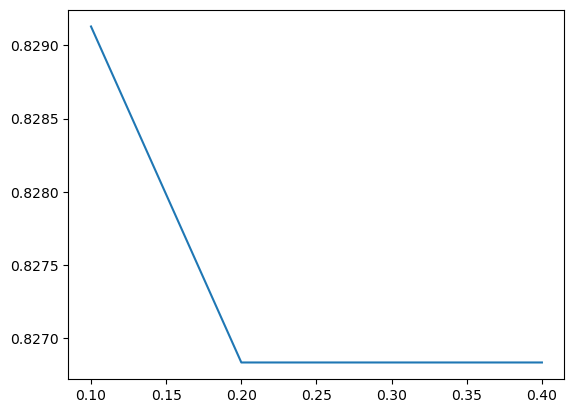

In [32]:
plt.plot(srand.reset_index().remove_pct, srand.accuracy)

### LOO Sweep Influence

In [33]:
def compute_loo_sweep(
    train_dataset, test_dataset, infl, config, sweep_lst
) -> pd.DataFrame:
    loo_dfs = []
    for remove_pct in sweep_lst:
        remove_length = int(remove_pct * len(train_dataset))
        print(f"---Remove Pct {remove_pct}: Remove Length: {remove_length}---")

        # Remove top influence score
        remove_idxs = np.argsort(-infl)[:remove_length]
        print(remove_idxs[:10])
        loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
        assert len(train_dataset) - remove_length == len(loo_dataset)
        loo_model = train_utils.train_bert_model(loo_dataset, test_dataset, config)
        tdf, rad_test_loss, rand_test_acc = train_utils.evaluate_loss(
            loo_model, test_dataloader
        )
        tdf["type"] = "top"

        # Remove bottom influence score
        remove_idxs = np.argsort(infl)[:remove_length]
        print(remove_idxs[:10])
        loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
        assert len(train_dataset) - remove_length == len(loo_dataset)
        loo_model = train_utils.train_bert_model(loo_dataset, test_dataset, config)
        bdf, rad_test_loss, rand_test_acc = train_utils.evaluate_loss(
            loo_model, test_dataloader
        )
        bdf["type"] = "bot"

        # Remove near 0 influence score
        remove_idxs = centered_percentile_idxs(infl, remove_length)
        print(remove_idxs[:10])
        loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
        assert len(train_dataset) - remove_length == len(loo_dataset)
        loo_model = train_utils.train_bert_model(loo_dataset, test_dataset, config)
        zdf, rad_test_loss, rand_test_acc = train_utils.evaluate_loss(
            loo_model, test_dataloader
        )

        zdf["type"] = "zero"

        # all_dfs = [rdf, tdf, bdf, zdf]
        all_dfs = [tdf, bdf, zdf]
        df = pd.concat(all_dfs, axis=0)
        df["remove_pct"] = remove_pct
        df.to_csv(f"remove-{remove_pct}.csv", index=False)
        loo_dfs.append(df)
    return pd.concat(loo_dfs)

In [34]:
# if_dir = Path("results_10k_reg001")
# all_if, no_data = load_all_influences(Path("results_10k_reg001"), 10000)
avg_infl = all_if.groupby("train_guid").mean().reset_index().sort_values("train_guid")

sweep_lst = [0.1, 0.2, 0.3, 0.4]
# Sweep for average influence across all test guids
df = compute_loo_sweep(
    train_dataset,
    test_dataset,
    avg_infl.influence.to_numpy(),
    retrain_config,
    sweep_lst,
)

---Remove Pct 0.1: Remove Length: 1000---
[1007 3911 2445 6180 1934 6268 5668 9081 1179 1948]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:17<00:00, 15.70batch/s]


[2426 6530 6263 2990 8543 1619 8833 7274 7127 2548]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:17<00:00, 15.76batch/s]


[8817 9740  150 7270 2569 6433 7486 8533 7849 1712]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:18<00:00, 15.59batch/s]


---Remove Pct 0.2: Remove Length: 2000---
[1007 3911 2445 6180 1934 6268 5668 9081 1179 1948]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 15.66batch/s]


[2426 6530 6263 2990 8543 1619 8833 7274 7127 2548]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 16.47batch/s]


[4792 7677 3600 8865  407 8627 5049 7396 3174 8585]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 15.77batch/s]


---Remove Pct 0.3: Remove Length: 3000---
[1007 3911 2445 6180 1934 6268 5668 9081 1179 1948]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:13<00:00, 15.83batch/s]


[2426 6530 6263 2990 8543 1619 8833 7274 7127 2548]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:13<00:00, 16.14batch/s]


[2342 4953 5295  616 5861 9504 2161 2289 3086  957]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:13<00:00, 15.75batch/s]


---Remove Pct 0.4: Remove Length: 4000---
[1007 3911 2445 6180 1934 6268 5668 9081 1179 1948]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.63batch/s]


[2426 6530 6263 2990 8543 1619 8833 7274 7127 2548]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.52batch/s]


[3442 3960 9497 2373 9763 1704 2064 5552 9619  558]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.51batch/s]


In [39]:
sum_infl = summarize_loo_df(df)
sum_infl

avg_loss  accuracy
type remove_pct                      
bot  0.1        0  0.539421  0.730505
     0.2        0  0.743771  0.641055
     0.3        0  1.089092  0.561927
     0.4        0  1.979719  0.513761
top  0.1        0  0.466184  0.795872
     0.2        0  0.629576  0.750000
     0.3        0  0.765133  0.715596
     0.4        0  0.992389  0.649083
zero 0.1        0  0.402743  0.826835
     0.2        0  0.407384  0.824541
     0.3        0  0.418097  0.827982
     0.4        0  0.432693  0.829128

In [40]:
sum_infl = summarize_loo_df(df)
sum_infl

avg_loss  accuracy
type remove_pct                      
bot  0.1        0  0.539421  0.730505
     0.2        0  0.743771  0.641055
     0.3        0  1.089092  0.561927
     0.4        0  1.979719  0.513761
top  0.1        0  0.466184  0.795872
     0.2        0  0.629576  0.750000
     0.3        0  0.765133  0.715596
     0.4        0  0.992389  0.649083
zero 0.1        0  0.402743  0.826835
     0.2        0  0.407384  0.824541
     0.3        0  0.418097  0.827982
     0.4        0  0.432693  0.829128

<Axes: >

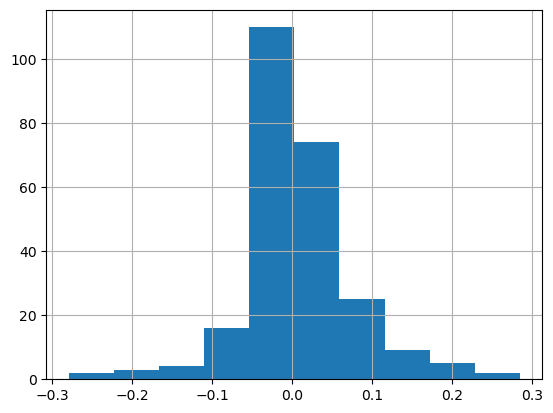

In [39]:
all_if[all_if.train_guid == 6263].infl_diff.hist()

In [34]:
avg_infl.sort_values('infl_diff')

,train_guid,influence,test_guid,infl_diff,abs_infl
8181,8181,0.918207,435.872,-0.009182,0.037710
6390,6390,0.827976,435.872,-0.008280,0.036514
9081,9081,0.826154,435.872,-0.008262,0.045711
8105,8105,0.822779,435.872,-0.008228,0.036465
1007,1007,0.816501,435.872,-0.008165,0.038837
...,...,...,...,...,...
8833,8833,-0.782116,435.872,0.007821,0.038686
8543,8543,-0.822028,435.872,0.008220,0.043302
6530,6530,-0.915507,435.872,0.009155,0.043384
2426,2426,-0.970863,435.872,0.009709,0.057795


In [41]:
pdf = sum_infl.reset_index()
pdf.to_csv('remove-influence.csv', index=False)

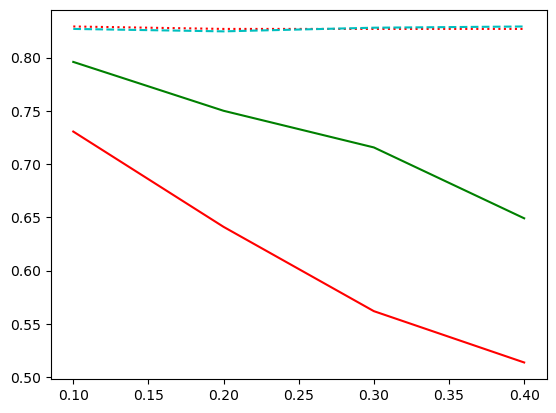

In [42]:
# pdf = sum_infl.reset_index()
# pdf = pd.read_csv("loo_sweep_results/influence_loo.csv")
# srand = pd.read_csv("loo_sweep_results/random_loo.csv")

plt.plot(srand.reset_index().remove_pct, srand.accuracy, "r:")

zero = pdf[pdf.type == "zero"]
plt.plot(zero.remove_pct, zero.accuracy, "c--")

top = pdf[pdf.type == "top"]
plt.plot(top.remove_pct, top.accuracy, "g-")

bot = pdf[pdf.type == "bot"]
plt.plot(bot.remove_pct, bot.accuracy, "r-")

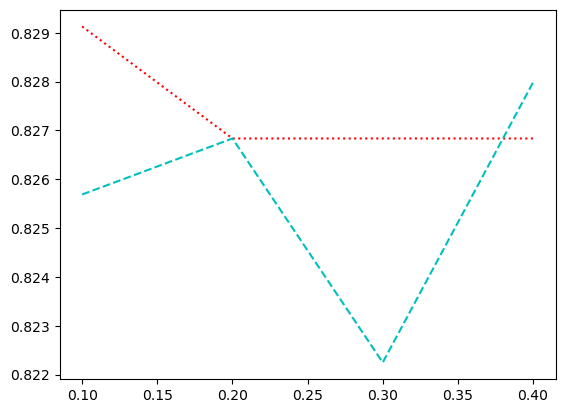

In [28]:
plt.plot(srand.reset_index().remove_pct, srand.accuracy, "r:")

zero = pdf[pdf.type == "zero"]
plt.plot(zero.remove_pct, zero.accuracy, "c--")

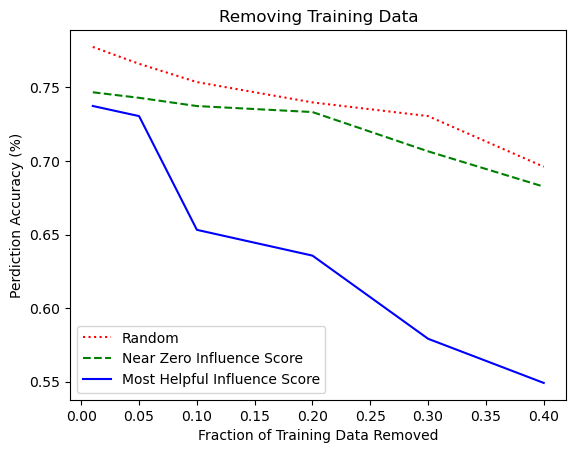

In [36]:
from matplotlib import pyplot as plt

pdf = pd.read_csv("loo_sweep_results/influence_loo.csv")
srand = pd.read_csv("loo_sweep_results/random_loo.csv")

plt.plot(srand.reset_index().remove_pct, srand.accuracy, "r:", label='Random')

zero = pdf[pdf.type == 'zero']
plt.plot(zero.remove_pct, zero.accuracy, "g--", label='Near Zero Influence Score')

# top = pdf[pdf.type == "top"]
# plt.plot(top.remove_pct, top.accuracy, "r-")

bot = pdf[pdf.type == "bot"]
plt.plot(bot.remove_pct, bot.accuracy, "b-", label='Most Helpful Influence Score')

plt.title('Removing Training Data')
plt.xlabel('Fraction of Training Data Removed')
plt.ylabel('Perdiction Accuracy (%)')
plt.legend()

In [50]:
df.groupby(["type", "remove_pct"]).mean().sort_values(["type", "remove_pct"])

/tmp/ipykernel_13093/566471095.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["type", "remove_pct"]).mean().sort_values(["type", "remove_pct"])


test_guid      pred     label      loss
type remove_pct                                         
bot  0.01            435.5  0.682339  0.509174  0.512243
     0.05            435.5  0.673165  0.509174  0.505404
     0.10            435.5  0.873853  0.509174  0.635568
     0.20            435.5  0.928899  0.509174  0.708639
     0.40            435.5  1.000000  0.509174  1.484117
rand 0.01            435.5  0.575688  0.509174  0.485304
     0.05            435.5  0.635321  0.509174  0.497645
     0.10            435.5  0.707569  0.509174  0.522196
     0.20            435.5  0.580275  0.509174  0.517005
     0.40            435.5  0.741972  0.509174  0.549613
top  0.01            435.5  0.565367  0.509174  0.483704
     0.05            435.5  0.379587  0.509174  0.470753
     0.10            435.5  0.387615  0.509174  0.466362
     0.20            435.5  0.286697  0.509174  0.531760
     0.40            435.5  0.016055  0.509174  1.023083

<Axes: >

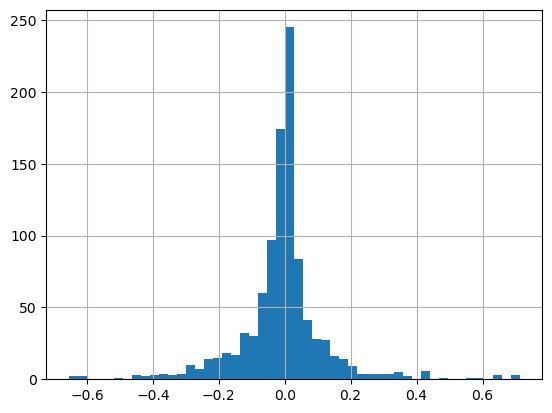

In [144]:
avg_infl.influence.hist(bins=50)

## Plot for Avg Loss

In [52]:
# TEST_GUID = 716
pdf = (
    df.groupby(["type", "remove_pct"])
    .mean()
    .reset_index()
    .sort_values(["type", "remove_pct"])
)
base_line_loss = fdf.loss.squeeze()

rand = pdf[(pdf.type == "rand")]
rand = rand[["remove_pct", "loss"]]

# zero = df[(df.type == "zero")]
# zero = zero[["remove_pct", "loss"]]

top = pdf[(pdf.type == "top")]
top = top[["remove_pct", "loss"]]

bot = pdf[(pdf.type == "bot")]
bot = bot[["remove_pct", "loss"]]

/tmp/ipykernel_13093/1621465221.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [10]:
rand

,remove_pct,loss
4,0.01,0.412868
5,0.05,0.406219
6,0.10,0.407622
7,0.20,0.425043


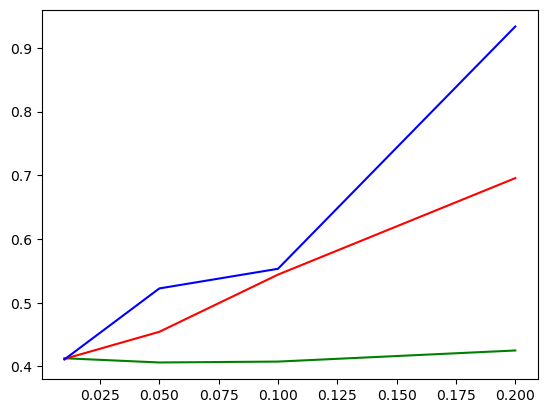

In [11]:
from matplotlib import pyplot as plt

plt.plot(rand.remove_pct, rand.loss, "g-")
# plt.plot(zero.remove_pct, zero.loss, "g--")

plt.plot(top.remove_pct, top.loss, "r-")
plt.plot(bot.remove_pct, bot.loss, "b-")

In [12]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

### Per Test GUID Analysis

In [ ]:
df[(df.type == "rand") & (df.test_guid == TEST_GUID)]

In [ ]:
df[(df.type == "top") & (df.test_guid == TEST_GUID)]

In [ ]:
df[(df.type == "bot") & (df.test_guid == TEST_GUID)]

In [ ]:
df[(df.type == "zero") & (df.test_guid == TEST_GUID)]

### Plot

In [ ]:
# TEST_GUID = 716
base_line_loss = fdf[fdf.test_guid == TEST_GUID].loss.squeeze()

rand = df[(df.type == "rand") & (df.test_guid == TEST_GUID)]
rand = rand[["remove_pct", "loss"]]

zero = df[(df.type == "zero") & (df.test_guid == TEST_GUID)]
zero = zero[["remove_pct", "loss"]]

top = df[(df.type == "top") & (df.test_guid == TEST_GUID)]
top = top[["remove_pct", "loss"]]

bot = df[(df.type == "bot") & (df.test_guid == TEST_GUID)]
bot = bot[["remove_pct", "loss"]]

In [ ]:
from matplotlib import pyplot as plt

plt.plot(rand.remove_pct, rand.loss, "g-")
plt.plot(zero.remove_pct, zero.loss, "g--")

plt.plot(top.remove_pct, top.loss, "r-")
plt.plot(bot.remove_pct, bot.loss, "b-")

In [ ]:
-

In [ ]:
base_line_loss

## Load Influence Results

In [ ]:
df_list = []
for test_guid in range(872):
    df = pd.read_csv(f"influence_results/influence-testguid-{test_guid}")
    df_list.append(df)

df = pd.concat(df_list)
avg_infl = df.groupby("train_guid").mean().reset_index()

In [ ]:
avg_infl.sort_values("influence", ascending=False).train_guid.iloc[:10].to_list()

In [ ]:
avg_infl.influence.hist()

In [ ]:
def retrain_model(model, config, train_dataset, remove_idxs):
    loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
    loo_dataloader = DataLoader(
        loo_dataset, batch_size=config["batch_size"], shuffle=True
    )

    loo_model = copy.deepcopy(model)

    optimizer = Adam(
        loo_model.classifier.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["optimizer_weight_decay"],
    )

    run = wandb.init(project="Bert-scratch", config=config)
    train_utils.train(
        config=config,
        model=loo_model,
        optimizer=optimizer,
        train_dataloader=loo_dataloader,
    )

    ldf, loo_loss, loo_acc = train_utils.evaluate_loss(loo_model, test_dataloader)
    wandb.summary["test/loss"] = loo_loss
    wandb.summary["test/accuracy"] = loo_acc
    wandb.finish()

    return loo_model, ldf, loo_loss, loo_acc

## Remove Random 10%

In [ ]:
remove_pct = 0.1

rand_hist = []
for remove_pct in [0.05, 0.1, 0.2, 0.3, 0.4]:
    remove_length = int(remove_pct * len(train_dataset))

    rand_idxs = np.random.choice(
        range(len(train_dataset)), remove_length, replace=False
    )
    loo_dataset = create_loo_dataset(train_dataset, rand_idxs)

    rand_model, rdf, rand_loss, rand_acc = retrain_model(
        model, config, train_dataset, rand_idxs
    )
    rdf["remove_pct"] = remove_pct
    rand_hist.append(rdf)

In [ ]:
rdf = pd.concat(rand_hist)
rdf.head()

In [ ]:
rdf.groupby("remove_pct").mean()

In [ ]:
rand_loss, rand_acc

In [ ]:
acc - rand_acc

## Remove Top 10% Influences

In [ ]:
remove_pct = 0.1

top_hist = []
for remove_pct in [0.05, 0.1, 0.2]:
    remove_length = int(remove_pct * len(train_dataset))

    top_indxs = (
        avg_infl.sort_values("influence", ascending=False)
        .train_guid.iloc[:remove_length]
        .to_list()
    )

    top_model, tdf, t_loss, t_acc = retrain_model(
        model, config, train_dataset, top_indxs
    )
    tdf["remove_pct"] = remove_pct
    top_hist.append(tdf)

tdf = pd.concat(top_hist)

In [ ]:
tdf.groupby("remove_pct").mean()

## Remove Bot 10%

In [ ]:
remove_pct = 0.1

bot_hist = []
for remove_pct in [0.05, 0.1, 0.2]:
    remove_length = int(remove_pct * len(train_dataset))

    bot_indxs = (
        avg_infl.sort_values("influence", ascending=True)
        .train_guid.iloc[:remove_length]
        .to_list()
    )

    bot_model, bdf, b_loss, b_acc = retrain_model(
        model, config, train_dataset, bot_indxs
    )
    bdf["remove_pct"] = remove_pct
    bot_hist.append(bdf)

bdf = pd.concat(bot_hist)

In [ ]:
bdf.groupby("remove_pct").mean()

In [ ]:
b_loss, b_acc

In [ ]:
acc - b_acc

In [ ]:
rand

## Remove Bottom 10% Influences

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

b_model, bdf, bot_test_loss, bot_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
fdf[fdf.test_guid == TEST_GUID]

In [ ]:
rdf[rdf.test_guid == TEST_GUID]

In [ ]:
tdf[tdf.test_guid == TEST_GUID]

In [ ]:
bdf[bdf.test_guid == TEST_GUID]

In [ ]:
import src.datasets as datasets

datasets.get_test_example(TEST_GUID).sentence.squeeze()

In [ ]:
fdf.sort_values("loss", ascending=False)